In [13]:
#Implementation of a semi-supervised or weakly supervised apporach on whole slide histropathological image and perform binary image classification.
#Name : Mir Siam
#ID : 213-15-4438 (60F_CSE)

#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [14]:
data = '/content/drive/MyDrive/Datasets for Breast Cancer/10264'
No_breast_cancer = '/content/drive/MyDrive/Datasets for Breast Cancer/10264/0'
Yes_breast_cancer = '/content/drive/MyDrive/Datasets for Breast Cancer/10264/1'

In [15]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  720    labels:  720


In [16]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(720,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Datasets for Breast Can...,No
1,/content/drive/MyDrive/Datasets for Breast Can...,No
2,/content/drive/MyDrive/Datasets for Breast Can...,No
3,/content/drive/MyDrive/Datasets for Breast Can...,No
4,/content/drive/MyDrive/Datasets for Breast Can...,No


In [17]:
print(df['labels'].value_counts())

No     617
Yes    103
Name: labels, dtype: int64


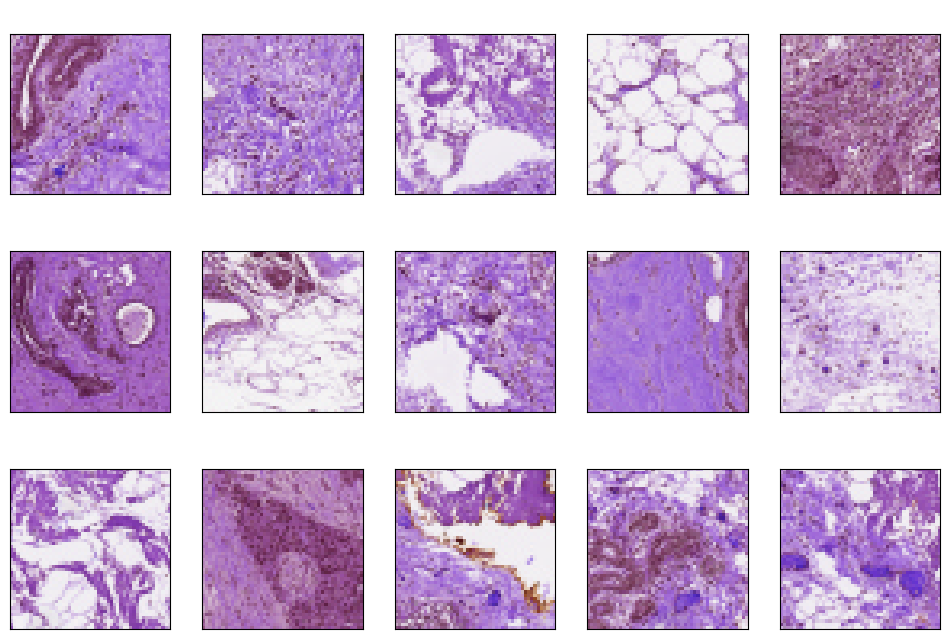

In [18]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (615, 2)
test set shape: (36, 2)
validation set shape: (69, 2)


In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)


In [21]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 615 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [22]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [23]:

from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23564800 (89.89 MB)
________________

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
20/20 [==============================] - 157s 8s/step - loss: 0.2701 - accuracy: 0.8748 - val_loss: 0.2856 - val_accuracy: 0.8406
Epoch 2/100
 5/20 [======>.......................] - ETA: 1:44 - loss: 0.2796 - accuracy: 0.8625

KeyboardInterrupt: 

In [ ]:
model.save("model.h5")

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Datasets for Breast Cancer/10264/0/10264_idx5_x101_y1651_class0.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

In [ ]:

train_gen.class_indices